# RF antenna: coax fed monopole over ground

## Overview
We simulate coax fed quarter-wave monopole antenna over ground plane. Nominally matched to 50 Ohm around 3 GHz. Please wait for v2.1 on 10/30 before running this example.

## Geometry

running luminescent python frontend


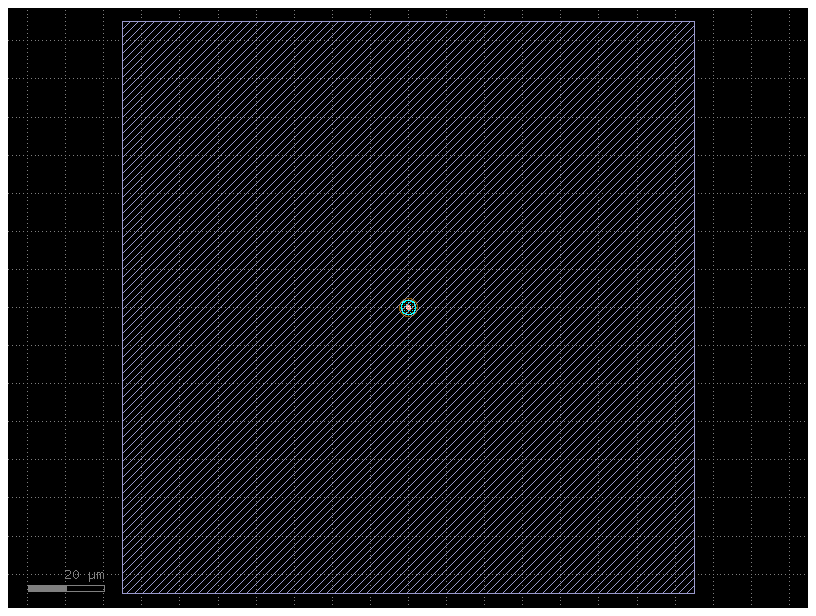

In [1]:
import math
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image

path = os.path.join("runs", "monopole")

# length and frequency units are arbitrary
f = 3  # GHz
bw = 2
df = 0.05
frequencies = np.linspace(f - bw / 2, f + bw / 2, round(bw / df) + 1).tolist()
wl1f = 300  # vacuum wavelength at 1 unit of frequency in your units
wl = wl1f / f  # characteristic wavelength

# below creates monopole antenna geometry in gdsfactory. however it's easier to create in a CAD program and import .obj mesh file

# coax
l_ant = wl / 4
d1 = 1  # center conductor diameter
d2 = 3.8  # shield inner diameter
thickness = 0.5  # shield thickness
d3 = d2 + 2 * thickness  # shield outer diameter

H = 3 * l_ant  # height of simulation domain above ground plane
L = 2 * H  # ground plane width
l_coax = d3
offset = 2 * thickness

WG = 1, 0
CLAD = 2, 0
SHIELD = 3, 0
GROUND = 4, 0

c = gf.Component()
core = c << gf.components.circle(radius=d1 / 2)
clad = c << gf.components.circle(radius=d2 / 2, layer=CLAD)
shield = c << gf.components.circle(radius=d3 / 2, layer=SHIELD)

gnd = c << gf.components.rectangle(size=(L, L), centered=True, layer=GROUND)
c.plot()

## Solve

Solving port modes with FEM...


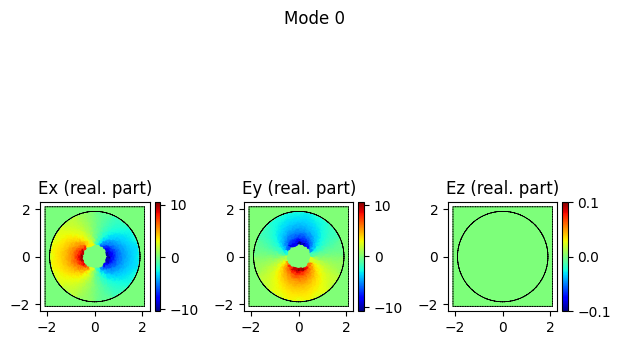

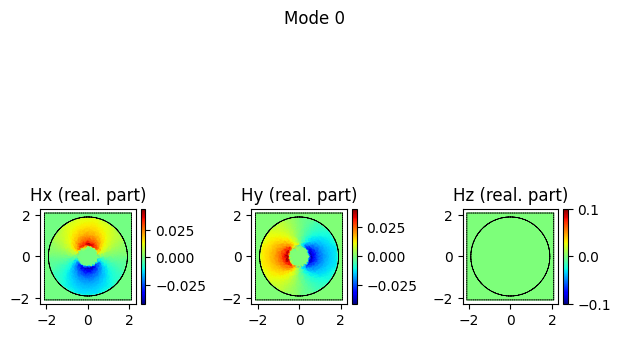

c:\Users\default.LAPTOP-HMRU58MH\anaconda3\Lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


using simulation folder c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\monopole


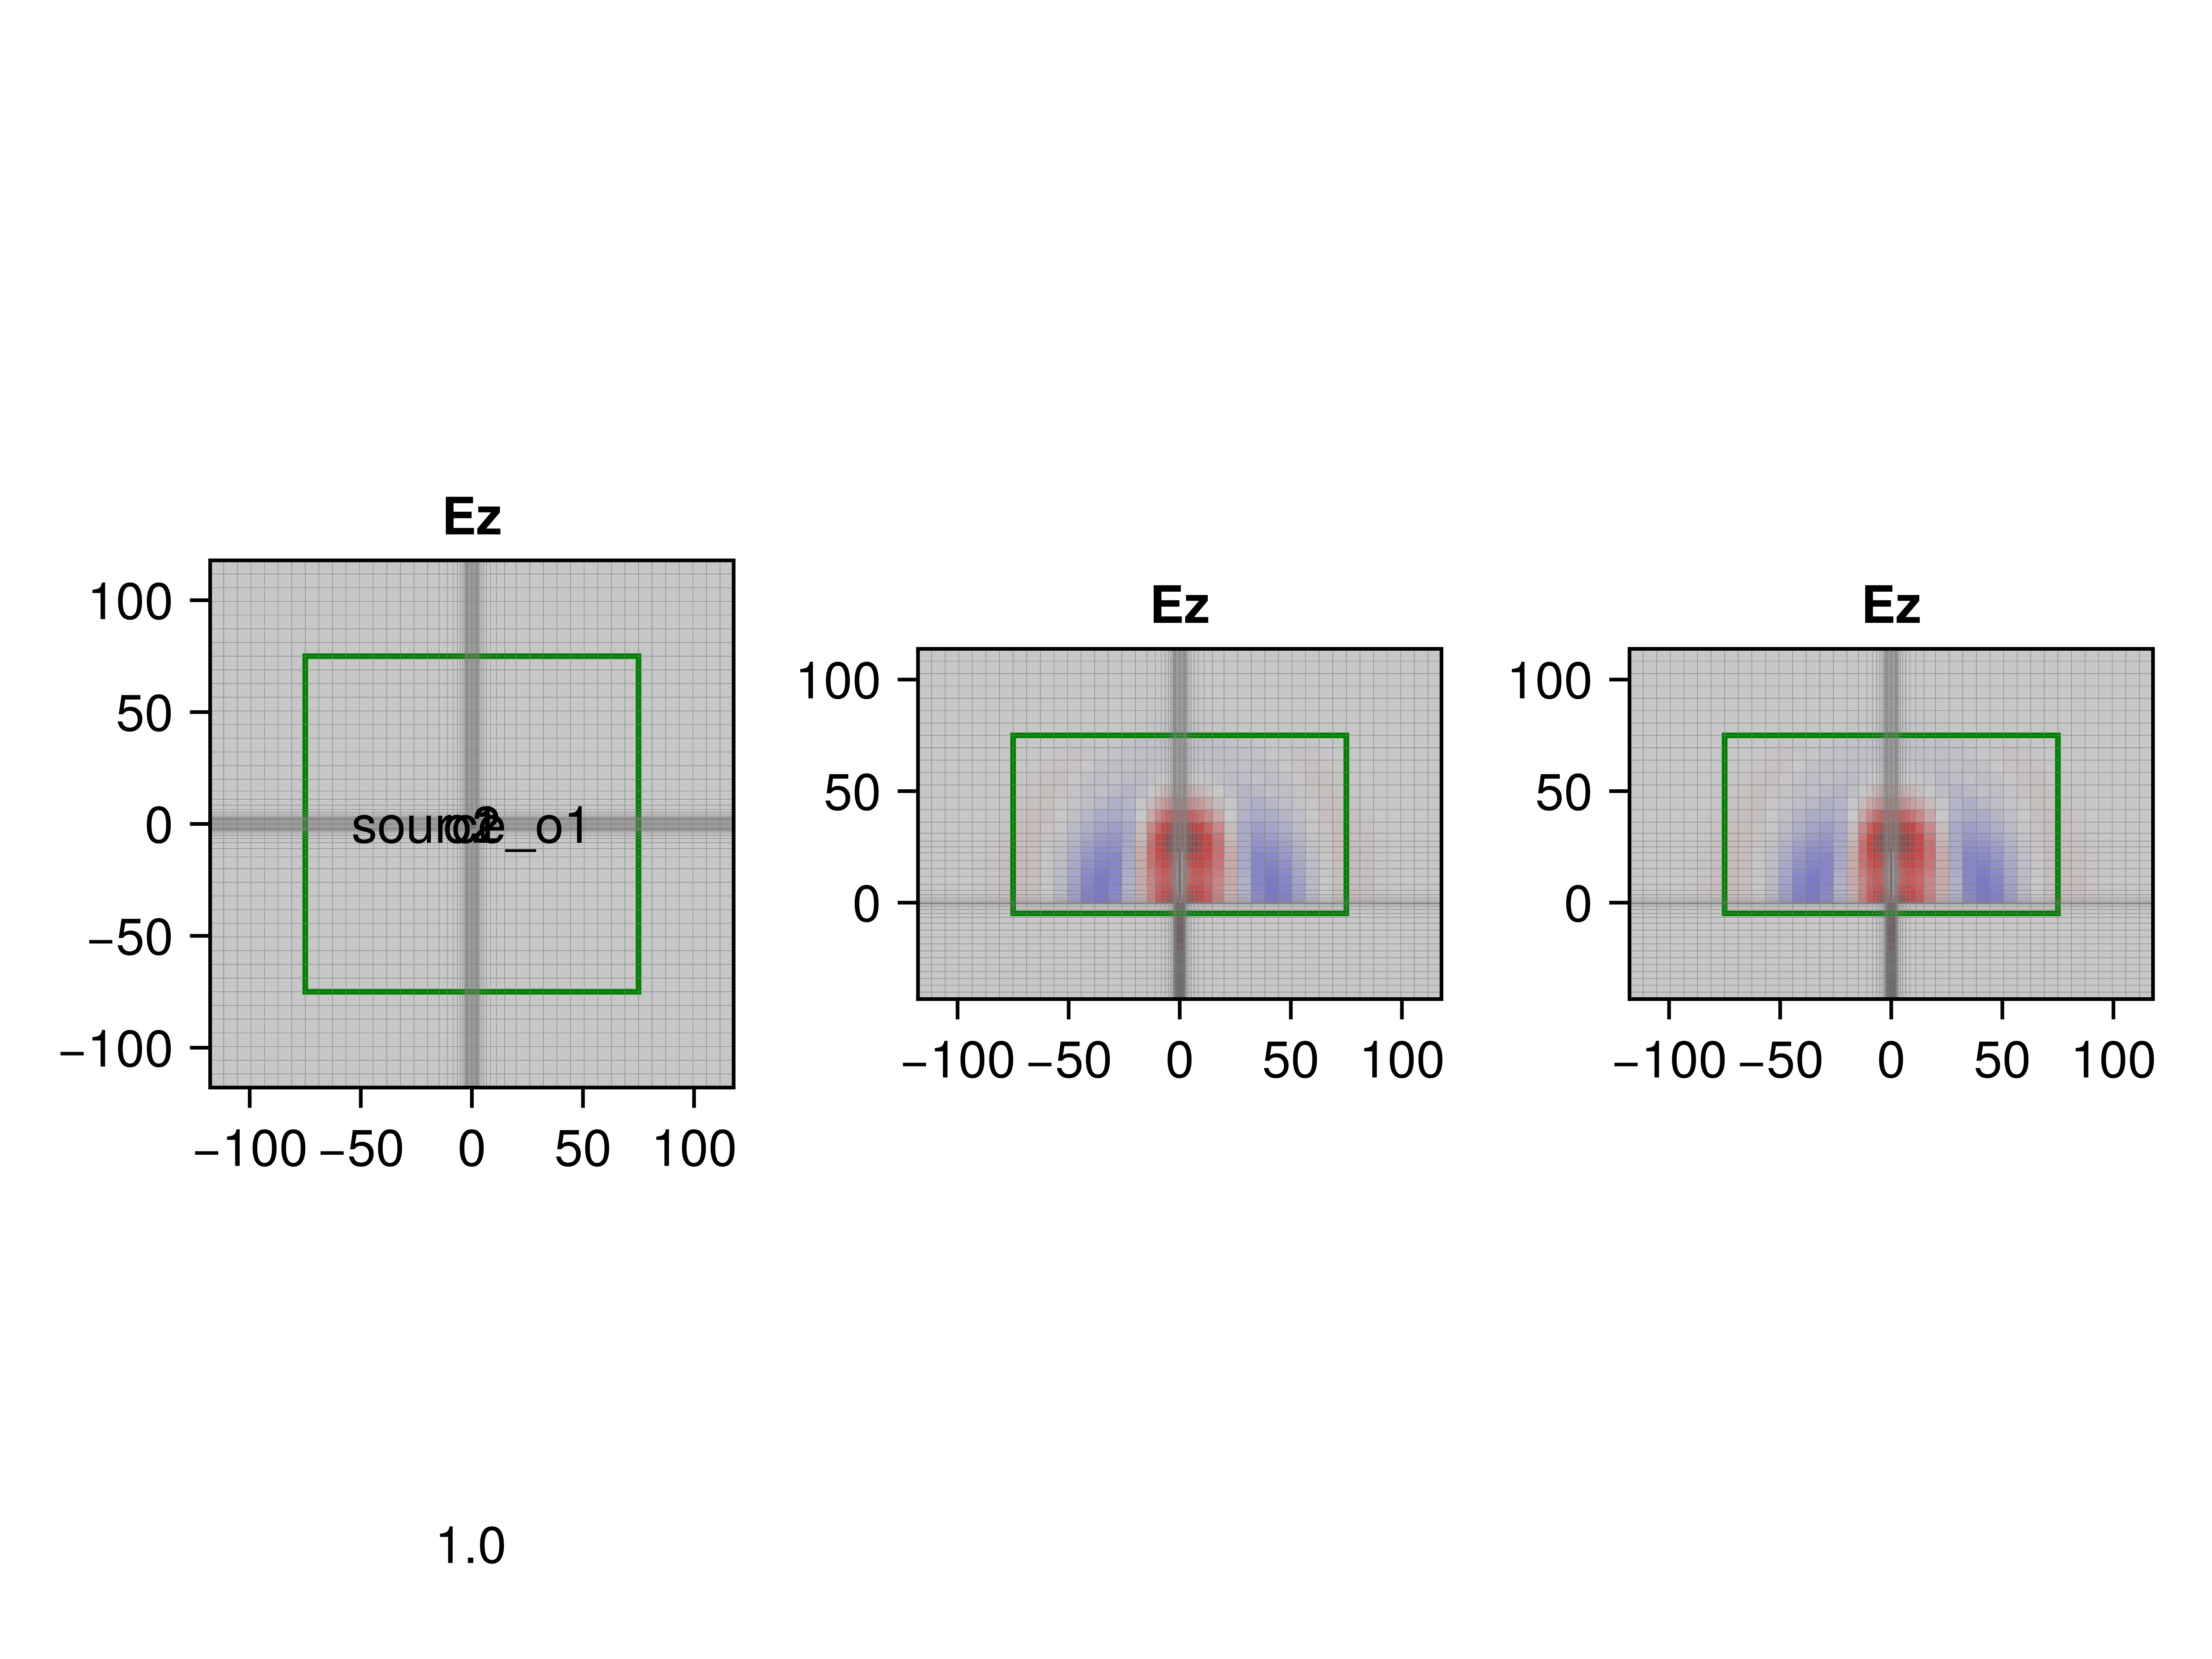

In [ ]:
layer_stack = LayerStack(
    layers={
        "core": LayerLevel(
            layer=LogicalLayer(layer=WG),
            zmin=-l_coax,
            thickness=l_coax + l_ant,
            material="PEC_coax",
            mesh_order=0,
        ),
        "clad": LayerLevel(
            layer=LogicalLayer(layer=CLAD),
            zmin=-l_coax,
            thickness=l_coax,
            material="FR",
            mesh_order=1,
        ),
        "shield": LayerLevel(
            layer=LogicalLayer(layer=SHIELD),
            zmin=-l_coax,
            thickness=l_coax,
            material="PEC_coax",
            mesh_order=2,
        ),
        "ground": LayerLevel(
            layer=LogicalLayer(layer=GROUND),
            zmin=-thickness,
            thickness=thickness,
            material="PEC_gnd",
            mesh_order=3,
        ),
    }
)

nres = 16
dx=.4
nPEC = wl / nres / dx
epsFR = 2.3  # relative permittivity of FR
nFR = math.sqrt(epsFR)

materials_library = lumi.MATERIALS_LIBRARY
materials_library["PEC_gnd"] = lumi.PECMaterial(mesh_density=1)
materials_library["PEC_coax"] = lumi.PECMaterial(mesh_density=[nPEC, nPEC, nFR])
materials_library["FR"] = lumi.Material(epsilon=epsFR)


angres = np.pi / 180 * 5  # angular resolution 
θmax = np.pi / 2
φmax = 2 * np.pi
ports = [
    lumi.PlanePort(
        name="o1",
        center=(0, 0, -offset),
        width=1.1 * d2,
        length=1.1 * d2,
        frame=[[1, 0, 0], [0, -1, 0], [0, 0, -1]],
    ),
    lumi.SpherePort(
        name="o2", center=(0, 0, 0), radius=.9*H, angres=angres, θmax=θmax, φmax=φmax
    ),
]

# ideal monopole mode fields for reference
# φ, θ = np.meshgrid(
#     np.linspace(0, 2 * np.pi, 37),
#     np.linspace(1e-3, np.pi / 2, 10),
# )
# Ey = np.cos(np.pi / 2 * np.cos(θ)) / np.sin(θ)
# Hx = -Ey

modes = [
    lumi.Mode(ports=["o1"], metallic_boundaries=["core", "clad"]),
    # lumi.Mode(ports=["o2"], fields=[{"Ey": Ey, "Hx": Hx}]),
]

sources = [
    lumi.Source("o1", source_port_margin=l_coax - thickness, frequency=f, bandwidth=1.)
]

kwargs = dict(
    path=path,
    component=c,
    frequency=f,
    frequencies=frequencies,
    wl1f=wl1f,
    #
    sources=sources,
    ports=ports,
    modes=modes,
    #
    materials_library=materials_library,
    layer_stack=layer_stack,
    zmin=-l_coax,
    zmax=H,
    #
    nres=nres,
    relative_courant=0.5,  # relative courant number between 0 and 1
    field_decay_threshold=0.01,  # field decay threshold for stopping simulation
    # visualization
    field_slices=[0, 0, -offset],
    geometry_slices=[0, 0, -offset],
    show_field="Ez",
    #
    saveat=1,
    force=True,  # override and delete simulation folder
    gpu='CUDA',
)
lumi.make_prob(**kwargs)
lumi.solve(path)
lumi.make_movie(path)
display(Image(os.path.join(path, "peak.png")))

## Analysis

loading solution from c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\monopole


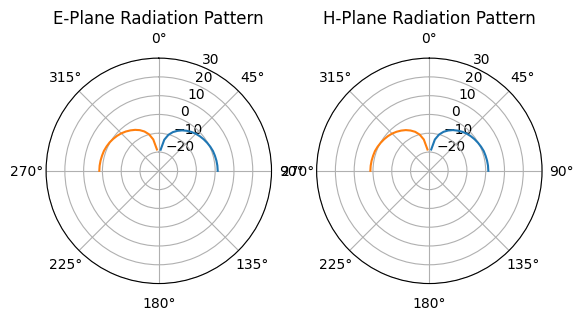

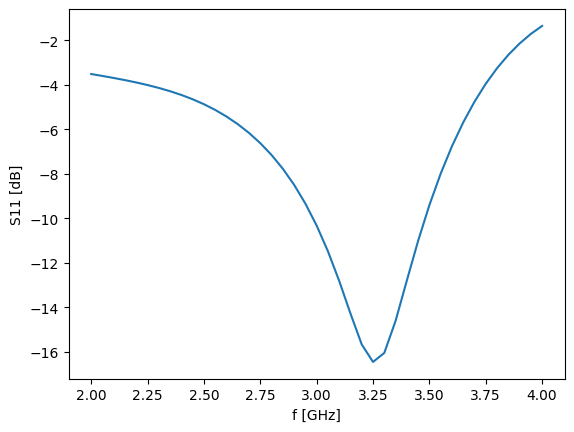

In [ ]:
sol = lumi.load_sol(path)

# S11 plot
fig = plt.figure()
x = frequencies
y = [10 * np.log10(v) for v in lumi.query(sol, "T1,1")]
# y = [10 * math.log10(v) for v in lumi.query(sol, "To2@0,o1@0")]

plt.plot(x, y)
plt.xlabel("f [GHz]")
plt.ylabel("S11 [dB]")
plt.show()

# Radiation pattern plots
flux = sol["dBi"]["o2"]
i = np.argmin(y)
nφ = round(φmax / angres) + 1
nθ = round(θmax / angres) + 1
θ = np.linspace(0, θmax, nθ)

flux_E_plane1 = flux[:, 0, i]
flux_E_plane2 = flux[:, round((nφ - 1) / 2), i]

flux_H_plane1 = flux[:, round((nφ - 1) / 4), i]
flux_H_plane2 = flux[:, round((nφ - 1) / 4 * 3), i]

fig = plt.figure()

ax = fig.add_subplot(121, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction("clockwise")
ax.plot(θ, flux_E_plane1)
ax.plot(-θ, flux_E_plane2)
ax.set_title("E-Plane Radiation Pattern")
ax.set_ylim(-30, 30)

ax = fig.add_subplot(122, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction("clockwise")
ax.plot(θ, flux_H_plane1)
ax.plot(-θ, flux_H_plane2)
ax.set_ylim(-30, 30)
ax.set_title("H-Plane Radiation Pattern")